## Библиотеки

In [8]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from collections import Counter

import warnings
warnings.filterwarnings("ignore")

## Функции

In [9]:
# https://github.com/benhamner/Metrics/blob/master/Python/ml_metrics/average_precision.py
def apk(actual, predicted, k=10):
    if len(predicted) > k:
        predicted = predicted[:k]

    score = 0.0
    num_hits = 0.0

    for i, p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i+1.0)

    if not actual:
        return 0.0

    return score / min(len(actual), k)

def mapk(actual, predicted, k=10):
    return np.mean([apk(a, p, k) for a, p in zip(actual, predicted)])

def make_csv(submission, name):
    submission = pd.DataFrame({'Id': df_test['Id'], 'Predicted': submission})
    submission['Predicted'] = submission.Predicted.astype(str).str.replace(',', '')
    submission.to_csv(f'{name}.csv', index=False)

## Получение данных

In [10]:
## df_train = pd.read_csv('/kaggle/input/alfabankchallengedata/df_train.csv', sep=';')
## df_test = pd.read_csv('/kaggle/input/alfabankchallengedata/df_test.csv', sep=';')
df_train = pd.read_csv('./df_train.csv', sep=';')
df_test = pd.read_csv('./df_test.csv', sep=';')

In [11]:
df_train['Data'] = df_train.Data.apply(lambda s: list(map(int, s.split(','))))
df_train['Target'] = df_train.Target.apply(lambda s: list(map(int, s.split(','))))
df_test['Data'] = df_test.Data.apply(lambda s: list(map(int, s.split(','))))

In [12]:
df_train.head()

,Id,Data,Target
0,0,"[4814, 4814, 6010, 6011, 4814, 6011, 6011, 481...","[4814, 4814, 4814, 4814, 5411, 4814, 4814, 481..."
1,1,"[6011, 6011, 6011, 6011, 6011, 6011, 6011, 481...","[4814, 6011, 4814, 6011, 4814, 4814, 6011, 481..."
2,2,"[8021, 6011, 6011, 6010, 4829, 4814, 6011, 601...","[6011, 6011, 6010, 4829, 4829, 6010, 6011, 601..."
3,3,"[4814, 6011, 4814, 4814, 4814, 6011, 6011, 569...","[6011, 6011, 6010, 6011, 6011, 4814, 4814, 601..."
4,4,"[4814, 4814, 4814, 4814, 4814, 4814, 5946, 481...","[5499, 6011, 4814, 4829, 5200, 5411, 5499, 591..."


In [13]:
df_train.shape

(7033, 3)

In [14]:
df_train.dtypes

Id         int64
Data      object
Target    object
dtype: object

In [15]:
df_test.head()

,Id,Data
0,0,"[4814, 4814, 6011, 6011, 6010, 6011, 6011, 481..."
1,1,"[6010, 6011, 6010, 5411, 5411, 5977, 6011, 601..."
2,2,"[4814, 6011, 5251, 6011, 7832, 5641, 5814, 482..."
3,3,"[6011, 4722, 4722, 4722, 4814, 6011, 6011, 482..."
4,4,"[4814, 4814, 4814, 6011, 4814, 4814, 4814, 481..."


In [16]:
df_test.shape

(7033, 2)

In [17]:
df_test.dtypes

Id       int64
Data    object
dtype: object

Идея 1 - предсказание, зависящее только от данных в df_train['Target'] на i-ой позиции.

In [18]:
class Idea1:
    def __init__(self, data):
        self.target = []
        for index_target in range(10):
            self.target.append(list(data['Target'].apply(lambda x: x[index_target])))

    def predict(self, count: int) -> list:
        def make_answer():
            answer = []
            for index_target in range(10):
                answer.append(random.choice(self.target[index_target]))

            return answer

        submission_data = []
        for id in range(count):
            submission_data.append(make_answer())

        return submission_data

model = Idea1(df_train)
submission = model.predict(df_test.shape[0])
make_csv(submission, 'Idea1')
mapk(df_train['Target'], submission)

0.1523357290686311

Идея 2 : разбить транзакции клиента на 10 частей и формировать вектор ответа на основе этого разбиения.

In [19]:
df_train['Data'].apply(len).min(), df_train['Data'].apply(len).max() # (train) количество транзакций на клиента лежит в (40, 21101)

(40, 21101)

In [20]:
df_test['Data'].apply(len).min(), df_test['Data'].apply(len).max() # (test) количество транзакций на клиента лежит в (40, 88771)

(40, 88771)

In [21]:
class Idea2:
    def predict(self, data: pd.DataFrame) -> list:
        def make_answer(client_data: list) -> list:
            answer = []
            lenght = len(client_data) // 10
            for i in range(10):
                answer.append(random.choice(client_data[i * lenght : (i + 1) * lenght if i != 9 else len(client_data)]))

            random.shuffle(answer) # ничем не подкрепленная гипотеза о перемешивании набора кодов дает чуть лучший результат по предложенной метрике
            return answer

        submission_data = []
        for client in data:
            submission_data.append(make_answer(client))

        return submission_data

model = Idea2()
submission = model.predict(df_test['Data'])
make_csv(submission, 'Idea2')
mapk(df_train['Target'], model.predict(df_train['Data']))

0.19173439725195734

Идея 3: константное предсказание на основе ОТВЕТОВ в обучающей выборке.

In [22]:
top10_codes = df_train['Target'].explode().value_counts().head(10)
top10_codes

6011    18373
4814    12961
5411    10518
4829     5920
6010     4960
5499     3623
5912     1485
5541     1344
5331     1339
5812      857
Name: Target, dtype: int64

In [23]:
constant_answer = top10_codes.index

In [24]:
class Idea3:
    def predict(self, data: pd.DataFrame) -> list:
        def make_answer() -> list:
            return constant_answer

        submission_data = []
        for client in range(len(data)):
            submission_data.append(make_answer())

        return submission_data

model = Idea3()
submission = model.predict(df_test['Data'])
make_csv(submission, 'Idea3')
mapk(df_train['Target'], model.predict(df_train['Data']))

0.28712452519753817

Идея 4: на коротком отрезке времени транзакции достаточно похожи.

In [25]:
class Idea4:
    def predict(self, data: pd.DataFrame) -> list:
        def make_answer(client_data: list) -> list:
            answer = []
            for i in range(10):
                answer.append(random.choice(client_data[-40:]))

            #random.shuffle(answer) # ничем не подкрепленная гипотеза о перемешивании набора кодов дает чуть лучший результат по предложенной метрике
            return answer

        submission_data = []
        for client in data:
            submission_data.append(make_answer(client))

        return submission_data

model = Idea4()
submission = model.predict(df_test['Data'])
make_csv(submission, 'Idea4')
mapk(df_train['Target'], model.predict(df_train['Data']))

0.19135855005540772

Идея 5: топ популярных cmm кодов за последнее время.

In [26]:
best_param = []
for _, client in df_train.iterrows():
    best_param.append(len(set(client['Target'])))
sum(best_param) / len(best_param)

4.511446040096687

In [27]:
class Idea5:
    def predict(self, data: pd.DataFrame) -> list:
        def make_answer(client_data: list) -> list:
            answer = list(pd.Series(client_data[-40:]).value_counts().head(5).index) # гиперпараметр в head
            i = 0
            while(len(answer) != 10):
                answer.append(answer[i])
                i += 1
            return answer

        submission_data = []
        for client in data:
            submission_data.append(make_answer(client))

        return submission_data

model = Idea5()
submission = model.predict(df_test['Data'])
make_csv(submission, 'Idea5')
mapk(df_train['Target'], model.predict(df_train['Data']))

0.2803637613157021

Идея 6: анализ поведения клиента, анализ cmm кодов, очистка объекта от "выбросов", if-else логика.

Учитывать категории, которыми пользовался клиент. Пробовать разные гиперпараметры.

In [28]:
len(pd.unique(df_train['Target'].explode()))

163

Text(0, 0.5, 'times')

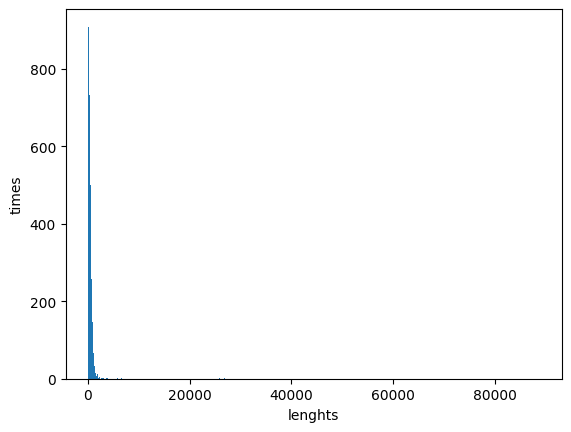

In [29]:
for_hist = []
for _, client in df_test.iterrows():
    for_hist.append(len(client['Data']))

plt.hist(for_hist, bins=len(set(for_hist)))
plt.xlabel('lenghts')
plt.ylabel('times')

In [30]:
piece = df_train.head(10)
piece['Data'] = piece['Data'].apply(lambda vec: vec if len(vec)<100 else vec[-100:])
piece.drop(['Id'], inplace = True, axis = 1)

for _, client in piece.iterrows():
    indexes = {}
    for i, cmm in enumerate(client['Data']):
        if cmm not in indexes:
            indexes[cmm] = []
        indexes[cmm].append(i)
    density = {}
    size_factor = len(client['Data']) / 100 # Для компенсации размера маленьких векторов
    for key in indexes:
        vec = indexes[key]
        if len(vec) >= 8 * size_factor:
            distance = 0
            for i in range(1, len(vec)):
                distance += vec[i] - vec[i - 1]
            distance /= len(vec)
            density[key] = (round(distance), round(len(vec) / size_factor)) # Более детально рассмотрим зависимость транзакций и target
    print(density, ' := ', client['Target'])
    print('=' * 140)

{4814: (3, 34), 5411: (4, 22), 6011: (4, 22), 5311: (4, 20)}  :=  [4814, 4814, 4814, 4814, 5411, 4814, 4814, 4814, 4814, 4814]
{6011: (2, 40), 4814: (2, 52)}  :=  [4814, 6011, 4814, 6011, 4814, 4814, 6011, 4814, 6011, 4814]
{6010: (5, 19), 4829: (6, 15), 4814: (6, 9), 5814: (3, 20)}  :=  [6011, 6011, 6010, 4829, 4829, 6010, 6011, 6011, 4814, 6011]
{5411: (2, 47), 4814: (4, 22), 6011: (4, 22)}  :=  [6011, 6011, 6010, 6011, 6011, 4814, 4814, 6011, 4814, 4814]
{6011: (5, 18), 4829: (9, 8), 4814: (5, 21), 5411: (5, 19), 6010: (7, 12)}  :=  [5499, 6011, 4814, 4829, 5200, 5411, 5499, 5912, 5411, 5912]
{6011: (3, 35), 5411: (6, 16), 4814: (9, 11)}  :=  [6011, 5331, 5411, 5411, 6011, 6010, 6011, 6011, 6011, 5411]
{4814: (8, 9), 5499: (2, 60), 5411: (9, 9), 6011: (7, 12)}  :=  [5499, 5499, 6010, 5411, 5411, 5499, 4814, 5499, 5411, 5499]
{6011: (1, 77), 6010: (9, 9)}  :=  [6011, 6011, 6010, 6011, 6011, 6011, 6011, 6011, 6011, 6011]
{4814: (1, 70), 5735: (6, 16), 6011: (9, 10)}  :=  [4814, 5735, 

In [31]:
top20_codes = df_train['Data'].explode().value_counts().head(20)
top20_codes

6011    700677
6010    490602
4814    473396
5411    472408
4829    307388
5499    164719
5541     68224
5912     65071
5331     61833
5812     52029
5814     47010
5921     28977
5999     25985
5977     17171
5311     16852
5964     16533
5691     14597
5983     14042
5211     13814
8999     11656
Name: Data, dtype: int64

In [32]:
categories = {
    'build': [1520, 1711, 1731, 1740, 1750, 1761, 5039, 5331, 5211], # 5331
    'print': [2741, 2791],
    'fly': [i for i in range(3000, 3006)],
    'drive': [4011, 4111, 4112, 4119, 4121, 4131, 5541, 5983],
    'equipment': [5021, 5044, 5045, 5046],
    'banks': [6010, 6011, 6012, 6022, 6023, 6025, 4829],
    'chill': [7011, 7012, 7032, 7033, 5812, 5814, 5921], # 5812, 5814, 5921
    'clean': [7210, 7211, 2842],
    'health': [742, 8011, 8021, 8031, 8041, 8042, 8043, 5912],
    'taxes': [9034, 9211, 9222, 9223, 9311, 9399],
    'eat': [5411, 5499, 5331, 5812, 5814, 5921, 5999, 5311]
    #'nowhere': [5977, 5964, 5691, 8999, 4814]
}

In [47]:
class Idea6:
    def predict(self, data: pd.DataFrame) -> list:
        def make_answer(client_data: list) -> list:
            answer = [0 for i in range(10)]
            lenght = len(client_data)
            piece = client_data if lenght < 100 else client_data[-100:]
            pools = {}
            indexes = {} # Индексы cmm кодов в последнем периоде транзакций
            density = {} # "Плотность cmm кода"

            for i, cmm in enumerate(piece):
                if cmm not in indexes:
                    indexes[cmm] = []
                indexes[cmm].append(i)
            size_factor = len(piece) / 100 # Для компенсации размера маленьких векторов
            indexes = {k: v for k, v in sorted(indexes.items(), key = lambda item: len(item[1]), reverse = True)}

            for key in indexes:
                vec = indexes[key]
                distance = 0
                for i in range(1, len(vec)):
                    distance += vec[i] - vec[i - 1]
                distance /= len(vec)
                density[key] = (round(distance), round(len(vec) / size_factor))

            for cmm_ans in density.keys(): # не больше 10
                pool = []
                counts = {cmm_ans: 0}
                cmm_category = 'noname'
                for category in categories: # 11 категорий
                    if cmm_ans in categories[category]:
                        cmm_category = category
                        break

                all = 0
                if cmm_category == 'noname':
                    for cmm in client_data: # o(N)
                        if cmm == cmm_ans:
                            all += 1
                else:
                    counts = {k: 0 for k in categories[cmm_category]}
                    for cmm in client_data: # o(N)
                        if cmm in categories[category]: # учитываем все cmm одной категории, которыми пользовался клиент
                            counts[cmm] += 1
                            all += 1

                counts = sorted(counts.items(), key = lambda item: item[1], reverse = True)
                for i in range(len(counts)):
                    if counts[i][0] == cmm_ans:
                        counts[0], counts[i] = counts[i], counts[0]
                        break
                mx = round(density[cmm_ans][1] / 10)
                for i in range(len(counts)):
                    if len(pool) == mx:
                        break
                    for k in range(min(round(counts[i][1] / all * 10), mx - len(pool))):
                        pool.append(counts[i][0])
                pools[cmm_ans] = (cmm_category, pool)

            pools = {k: v for k, v in sorted(pools.items(), key = lambda item: density[item[0]][0], reverse = True)}
            for cmm in pools:
                start = 1

                if pools[cmm][0] == 'noname':
                    while piece[-start] != cmm:
                        start += 1
                else:
                    while piece[-start] not in categories[pools[cmm][0]]:
                        start += 1
                mark = period = density[cmm][0] # Опираемся на частоту использования категории
                pool_i = 0
                pool = pools[cmm][1]
                while(mark < start + 10 and pool_i < len(pool)):
                    if mark > start and answer[mark - start] == 0:
                        answer[mark - start] = pool[pool_i]
                        pool_i += 1
                        mark += period
                    else:
                        mark += 1

                if pool_i < len(pool):
                    for i in range(10):
                        if pool_i == len(pool):
                            break
                        if answer[i] == 0:
                            answer[i] = pool[pool_i]
                            pool_i += 1

            ans_i = 0
            for i in range(10):
                if answer[i] == 0:
                    answer[i] = piece[-ans_i]
                    ans_i += 1

            return answer

        submission_data = []
        for client in data:
            submission_data.append(make_answer(client))

        return submission_data

model = Idea6()
submission = model.predict(df_test['Data'])
make_csv(submission, 'Idea6')
mapk(df_train['Target'], model.predict(df_train['Data']))

0.2137541160831364

In [48]:
class Idea7:
    def predict(self, data: pd.DataFrame) -> list:
        def make_answer(client_data: list) -> list:
            lenght = len(client_data)
            piece = client_data if lenght < 100 else client_data[-100:]
            indexes = {} # Индексы cmm кодов в последнем периоде транзакций
            for i, cmm in enumerate(piece):
                if cmm not in indexes:
                    indexes[cmm] = []
                indexes[cmm].append(i)

            density = {} # "Плотность cmm кода"
            size_factor = len(piece) / 100 # Для компенсации размера маленьких векторов
            indexes = {k: v for k, v in sorted(indexes.items(), key = lambda item: len(item[1]), reverse = True)}
            for key in indexes:
                vec = indexes[key]
                distance = 0
                for i in range(1, len(vec)):
                    distance += vec[i] - vec[i - 1]
                distance /= len(vec)
                density[key] = (round(distance), round(len(vec) / size_factor))
            answer = [0 for i in range(10)]
            for cmm_ans in density.keys(): # не больше 10
                start = 1
                while piece[-start] != cmm_ans:
                    start += 1

                period = density[cmm_ans][0] # Опираемся на частоту использования категории
                mark = period
                pool_i = 0
                pool = round(density[cmm_ans][1] / 10)
                while(mark < start + 10 and pool_i < pool):
                    if mark > start and answer[mark - start] == 0:
                        answer[mark - start] = cmm_ans
                        pool_i += 1
                        mark += period
                    else:
                        mark += 1

                if pool_i < pool:
                    for i in range(10):
                        if pool_i == pool:
                            break
                        if answer[i] == 0:
                            answer[i] = cmm_ans
                            pool_i += 1
            ans_i = 0
            for i in range(10):
                if answer[i] == 0:
                    answer[i] = piece[-ans_i]
                    ans_i += 1

            return answer

        submission_data = []
        for client in data:
            submission_data.append(make_answer(client))

        return submission_data

model = Idea7()
submission = model.predict(df_test['Data'])
make_csv(submission, 'Idea7')
mapk(df_train['Target'], model.predict(df_train['Data']))

0.23493421602016792

## Baseline 1: топ10 MCC-кодов из train-части

MCC-код и соответствующее количество вхождений в train-часть

In [33]:
mapk(df_train['Target'], [top10_codes.index]*len(df_train))

0.28712452519753817

## Baseline 2: cамые популярные транзакции пользователя.

**Если таких менее 10, то замешиваются топ10 популярных из всей выборки.**

In [34]:
def get_top_codes(transactions, top_n=10, drop_from=5):
    transactions_stats = sorted(
        Counter(transactions).items(),
        key=lambda x: x[1],
        reverse=True
    )[:top_n]


    top_codes = [mcc_code for (mcc_code, count) in transactions_stats if count >= drop_from]
    top_codes += list(top10_codes.index)

    return top_codes[:10]

In [35]:
df_train['pred_baseline_2'] = df_train['Data'].apply(get_top_codes)

In [36]:
mapk(df_train['Target'], df_train['pred_baseline_2'])

0.32322282820896503